In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict

def match_countries(df1, df2):

    # Initialize nltk tokenizer and stopwords dictionary
    pattern = r'''(?x)          # set flag to allow verbose regexps
            (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
          | \w+(?:-\w+)*        # words with optional internal hyphens
        '''
    tokenizer = RegexpTokenizer(pattern)
    stop_words = stopwords.words('english') + ['rep', 'republic']

    # Filter unmatched countries in df1 and df2
    df1_unmatched = pd.DataFrame(index = set(df1[~df1['Country'].isin(df2['Country'])]['Country']))
    df2_unmatched = pd.DataFrame(index = set(df2[~df2['Country'].isin(df1['Country'])]['Country']))

    # Tokenize unmatched country names from df1 dataset
    df1_countries = [tokenizer.tokenize(i) for i in df1_unmatched.index]
    df1_countries = list(map(lambda tokens: [t for t in tokens if t.lower() not in stop_words], df1_countries))
    df1_unmatched['tokenized'] = df1_countries

    # Tokenize unmatched country names from df2 dataset
    df2_countries = [tokenizer.tokenize(i) for i in df2_unmatched.index]
    df2_countries = list(map(lambda tokens: [t for t in tokens if t.lower() not in stop_words], df2_countries))
    df2_unmatched['tokenized'] = df2_countries

    # Initialize empty dictionary to store match counts
    matches = defaultdict(dict)

    # Iterate through unmatched df1 country names
    for index1, tokens1 in df1_unmatched.itertuples():

        # Iterate through unmatched df2 country names
        for index2, tokens2 in df2_unmatched.itertuples():

            # Store match counts between tokenized country names
            matches[index1][index2] = len([t for t in tokens1 if t.startswith(tuple(tokens2))] + 
                                          [t for t in tokens2 if t.startswith(tuple(tokens1))])

    # Convert dictionary to dataframe        
    matches = pd.DataFrame.from_dict(matches)

    # Initialize empty dictionary for matched country names
    countries = {}

    # Iterate through match counts between country names
    for index, match in matches.iterrows():

        # Find matching country name based on max match count in forward direction
        forward_match = np.where(match == np.amax(match))[0].tolist()

        # Make sure only one matching country name in forward direction
        if len(forward_match) == 1:

            # Find matching country name based on max match count in reverse direction
            reverse_match = np.where(matches.iloc[:, forward_match] == np.amax(matches.iloc[:, forward_match]))[0].tolist()

            # Make sure only one matching country name in reverse direction
            if len(reverse_match) == 1:

                # Store matching country name pair as key-value pair
                countries[matches.iloc[reverse_match, forward_match].index[0]] = matches.iloc[reverse_match, forward_match].columns[0]
                
    return countries

1. Using the pandas `read_csv()` function, read the GDP dataset into your notebook as a DataFrame called `gdp_df`. 
    * Take a look at the first 10 rows. 
    * Look at the last 5 rows. Do you see a problem?
    * Redo the `read_csv()` call to correct this issue - **do not** modify the original csv file.

In [44]:
gdp_df = pd.read_csv('../data/gdp_per_capita.csv')
display(gdp_df.head(10))
display(gdp_df.tail())

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2019,2065.036398,NaN
1,Afghanistan,2018,2033.779002,NaN
2,Afghanistan,2017,2058.383832,NaN
3,Afghanistan,2016,2057.062164,NaN
4,Afghanistan,2015,2068.265904,NaN
5,Afghanistan,2014,2102.385234,NaN
6,Afghanistan,2013,2116.465454,NaN
7,Afghanistan,2012,2075.491747,NaN
8,Afghanistan,2011,1904.559799,NaN
9,Afghanistan,2010,1957.029338,NaN


,Country or Area,Year,Value,Value Footnotes
6865,Zimbabwe,1992,3054.889178,NaN
6866,Zimbabwe,1991,3426.598094,NaN
6867,Zimbabwe,1990,3324.348171,NaN
6868,footnoteSeqID,Footnote,NaN,NaN
6869,2,"Excludes South Sudan after July 9, 2011.",NaN,NaN


In [73]:
gdp_df = pd.read_csv('../data/gdp_per_capita.csv', nrows = 6868)

6. Drop the 'Value Footnotes' column, and rename the remaining columns to ‘Country’, ‘Year’, and ‘GDP_Per_Capita’.

In [74]:
gdp_df = gdp_df.drop(columns = 'Value Footnotes')
gdp_df.columns = ['Country', 'Year', 'GDP_Per_Capita']

7. How many rows and columns does `gdp_df` have? What are the data types of its columns? If any of the columns are not the expected types, figure out why and fix it.

In [75]:
display(gdp_df.info())

# gdp_df has 6868 rows and 3 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6868 entries, 0 to 6867
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         6868 non-null   object 
 1   Year            6868 non-null   int64  
 2   GDP_Per_Capita  6868 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 161.1+ KB


None

8. Which years are represented in this dataset? Take a look at the number of observations per year. What do you notice?

In [76]:
display(gdp_df['Year'].value_counts())

# There are less observations for earlier years compared to more recent years.

2013    238
2014    238
2016    238
2015    238
2017    238
2012    237
2018    237
2011    237
2009    236
2010    236
2007    235
2008    235
2006    235
2004    234
2005    234
2002    233
2003    233
2001    232
2019    231
2000    231
1999    224
1998    223
1997    223
1996    221
1995    221
1994    214
1993    212
1992    209
1991    208
1990    207
Name: Year, dtype: int64

9. How many countries are represented in this dataset? Which countries are least represented in the dataset? Why do you think these countries have so few observations?

In [77]:
display(gdp_df['Country'].value_counts())

# There are 238 entries in this dataset, the vast majority of which are countries. Djibouti (7), Turks and Caicos Islands (9), and Sint Maarten (10) have the least observations in the dataset, likely because these countries lack reliable data collection.

Philippines                  30
Solomon Islands              30
Kenya                        30
Ghana                        30
Ethiopia                     30
                             ..
Nauru                        16
Cayman Islands               13
Sint Maarten (Dutch part)    10
Turks and Caicos Islands      9
Djibouti                      7
Name: Country, Length: 238, dtype: int64

10. Create a new dataframe by subsetting `gdp_df` to just the year 2014. Call this new dataframe `gdp_2014`.

In [78]:
gdp_2014 = gdp_df[gdp_df['Year'] == 2014]

11. Use `.describe()` to find the summary statistics for GDP per capita in 2014. 

In [79]:
display(gdp_2014.describe())

,Year,GDP_Per_Capita
count,238.0,238.000000
mean,2014.0,19766.710348
std,0.0,20983.869623
min,2014.0,822.610458
25%,2014.0,4753.110934
50%,2014.0,12209.385755
75%,2014.0,26803.610474
max,2014.0,156514.133850


12. Create a histogram of GDP Per Capita numbers for 2014 (you may wish to adjust the number of bins for your histogram). How would you describe the shape of the distribution?

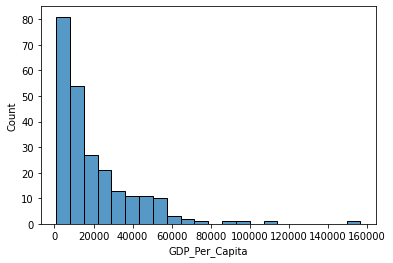

In [80]:
sns.histplot(gdp_2014['GDP_Per_Capita']);

# The distribution is right-skewed unimodal.

13. Find the top 5 counties and bottom 5 countries by GDP per capita in 2014.

In [81]:
display(gdp_2014.sort_values('GDP_Per_Capita', ascending = False).head())
display(gdp_2014.sort_values('GDP_Per_Capita', ascending = True).head())

,Country,Year,GDP_Per_Capita
3721,"Macao SAR, China",2014,156514.133850
3691,Luxembourg,2014,108760.916030
5138,Qatar,2014,95578.416973
5464,Singapore,2014,87808.663157
561,Bermuda,2014,77361.104881


,Country,Year,GDP_Per_Capita
1047,Central African Republic,2014,822.610458
827,Burundi,2014,886.235777
3781,Malawi,2014,1027.208496
1422,Dem. Rep. Congo,2014,1029.790785
4528,Niger,2014,1127.615541


14. Now, return to the full dataset, `gdp_df`. Pivot the data for 1990 and 2017 (using the pandas `.pivot_table()` method or another method) so that each row corresponds to a country, each column corresponds to a year, and the values in the table give the GDP_Per_Capita amount. Drop any rows that are missing values for either 1990 or 2017. Save the result to a dataframe named `gdp_pivoted`.

In [86]:
gdp_pivoted = gdp_df[gdp_df['Year'].isin([1990,2017])].pivot_table('GDP_Per_Capita', index = 'Country', columns = 'Year')
gdp_pivoted = gdp_pivoted.dropna()
display(gdp_pivoted)

Year,1990,2017
Country,,
Albania,4842.734635,12811.759436
Algeria,8746.352901,11737.409353
Angola,5783.429064,7310.901738
Antigua and Barbuda,15459.551675,19840.076123
Arab World,9694.667544,14555.474921
...,...,...
Vanuatu,2888.309393,3116.645194
Vietnam,1673.249634,7155.745829
World,9680.269697,16253.385518


15. Create a new column in `gdp_pivoted` named `Percent_Change`. This column should contain the percent change in GDP_Per_Capita from 1990 to 2017. Hint: Percent change is calculated as 100*(New Value - Old Value) / Old Value.

In [15]:
gdp_pivoted['Percent_Change'] = 100 * (gdp_pivoted.loc[:, 2017] - gdp_pivoted.loc[:, 1990]) / gdp_pivoted.loc[:, 1990]

16. How many countries experienced a negative percent change in GDP per capita from 1990 to 2017?

In [16]:
display(sum(gdp_pivoted['Percent_Change'] < 0))

# 17 countries experienced a negative percent change in GDP per capita from 1990 to 2017.

17

17. Which country had the highest % change in GDP per capita? Create a line plot showing this country's GDP per capita for all years from 1990 to 2017. Create another showing the country with the second highest % change in GDP. How do the trends in these countries compare?  
    **Bonus:** Put both line charts on the same plot.

Year,1990,2017,Percent_Change
Country,,,
Equatorial Guinea,1039.985049,22551.083246,2068.404561
China,1423.896348,14344.421239,907.406281


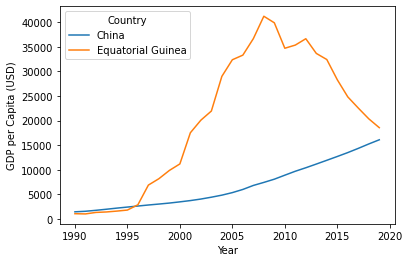

In [17]:
display(gdp_pivoted.sort_values('Percent_Change', ascending = False).head(2))

gdp_plot_data = gdp_df[gdp_df['Country'].isin(['Equatorial Guinea', 'China'])]
sns.lineplot(data = gdp_plot_data, x = 'Year', y = 'GDP_Per_Capita', hue = 'Country')
plt.ylabel('GDP per Capita (USD)');

# Equatorial Guinea and China had the first and second highest percent change in GDP, respectively.

18. Read in continents.csv contained in the `data` folder into a new dataframe called `continents`. We will be using this dataframe to add a new column to our dataset.


In [18]:
continents = pd.read_csv('../data/continents.csv')

19. Merge gdp_df and continents. Keep only the countries that appear in both data frames. Save the result back to gdp_df.

In [19]:
continents_gdp_matches = match_countries(continents, gdp_df)
display(continents_gdp_matches)

{'Sint Maarten (Dutch part)': 'Sint Maarten',
 'SÃ£o TomÃ© and Principe': 'Sao Tome and Principe'}

In [20]:
gdp_df = gdp_df.assign(temp = list(map(continents_gdp_matches.get, gdp_df['Country'])))
gdp_df['Country'] = np.where(~gdp_df['temp'].isna(), gdp_df['temp'], gdp_df['Country'])
gdp_df = gdp_df.drop(columns = 'temp')
gdp_df = continents.merge(gdp_df, on = 'Country')

20. Determine the number of countries per continent. Create a bar chart showing this.

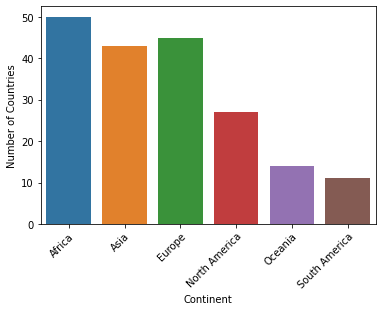

In [21]:
countries_by_continent = gdp_df.groupby('Continent').agg({'Country' : pd.Series.nunique})
sns.barplot(data = countries_by_continent, x = countries_by_continent.index, y = 'Country')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.ylabel('Number of Countries');

21. Create a seaborn boxplot showing GDP per capita in 2014 split out by continent. What do you notice?

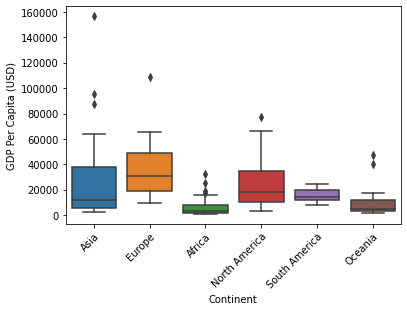

In [22]:
sns.boxplot(data = gdp_df[gdp_df['Year'] == 2014], x = 'Continent', y = 'GDP_Per_Capita')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.ylabel('GDP Per Capita (USD)');

# Europe and Africa had the highest and lowest median GDP per capita in 2014, respectively. Three of the top four highest GDP per capitas were countries in Asia.

22. Read in internet_use.csv into a DataFrame called `internet_df`. You will most likely get an error message when doing this - figure out what is going wrong and fix it. Take a look at the first and last five rows and make any corrections to your `read_csv()` call to fix this. Again, **do not** modify the original datasets. 

In [23]:
internet_df = pd.read_csv('../data/internet_use.csv', nrows = 4495)

23. Drop the Value Footnotes column and then rename the columns to ‘Country’, ‘Year’, and ‘Internet_Users_Pct’.

In [24]:
internet_df = internet_df.drop(columns = 'Value Footnotes')
internet_df.columns = ['Country', 'Year', 'Internet_Users_Pct']

24. How many rows and columns does this new dataset have? What are the types of its columns? Ensure that the `Internet_Users_Pct` column is a numeric data type and fix it if it is not.

In [25]:
display(internet_df.info())

# internet_df has 4495 rows and 3 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4495 entries, 0 to 4494
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             4495 non-null   object 
 1   Year                4495 non-null   int64  
 2   Internet_Users_Pct  4495 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 105.5+ KB


None

25. What is the first year that has a nonzero internet users percentage reported? What is the general trend in internet users percentage over the years. Pick a visualization that you think illustrates this trend well.

,Country,Year,Internet_Users_Pct
2048,Italy,1990,0.017545
1107,Denmark,1990,0.097277
375,Belgium,1990,0.001007
1388,Finland,1990,0.401088
4301,United States,1990,0.784729
...,...,...,...
2175,Kiribati,2014,12.250000
848,Colombia,2014,52.570000
1299,Ethiopia,2014,2.900000
623,Burundi,2014,1.380000


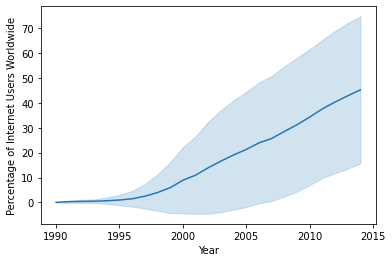

In [26]:
display(internet_df[internet_df['Internet_Users_Pct'] > 0].sort_values('Year'))
sns.lineplot(data = internet_df[internet_df['Year'] >= 1990], x = 'Year', y = 'Internet_Users_Pct', ci = 'sd')
plt.ylabel('Percentage of Internet Users Worldwide');

# 1990 is the first year that has non-zero internet users percentage. The general trend in internet users percentage is an increase over time.

26. Merge `gdp_df` and `internet_df` (on Country and Year) into a single DataFrame named `gdp_and_internet_use`. Keep only countries and years that appear in both tables.  
    **Difficult Bonus:** Do not attempt this part until you have completed all other portions of the data question. Some countries have slightly different names in the internet use and gdp dataframes. For example, the Central African Republic is "Central African Republic" in the gdp dataframe and "Central African Rep." in the internet use dataframe. Find as many instances like this as you can and resolve them so that when merging you keep the maximum number of countries possible.

In [27]:
gdp_internet_matches = match_countries(gdp_df, internet_df)
display(gdp_internet_matches)

{'Micronesia (Fed. States of)': 'Micronesia',
 'Dominican Rep.': 'Dominican Republic',
 'Bahamas': 'The Bahamas',
 'Central African Rep.': 'Central African Republic',
 'Lao P.D.R.': 'Lao PDR',
 'Viet Nam': 'Vietnam',
 'T.F.Y.R. Macedonia': 'North Macedonia',
 'Congo (Democratic Republic of the)': 'Dem. Rep. Congo',
 'Saint Kitts and Nevis': 'St. Kitts and Nevis',
 'Hong Kong, China': 'Hong Kong SAR, China',
 'Kyrgyzstan': 'Kyrgyz Republic',
 'Brunei Darussalam': 'Brunei',
 'Macao, China': 'Macao SAR, China',
 'Saint Lucia': 'St. Lucia',
 'Iran (Islamic Rep. of)': 'Iran',
 'Cape Verde': 'Cabo Verde',
 'Gambia': 'The Gambia'}

In [28]:
internet_df = internet_df.assign(temp = list(map(gdp_internet_matches.get, internet_df['Country'])))
internet_df['Country'] = np.where(~internet_df['temp'].isna(), internet_df['temp'], internet_df['Country'])
internet_df = internet_df.drop(columns = 'temp')
gdp_and_internet_use = gdp_df.merge(internet_df, on = ['Country', 'Year'])

27.	Look at the first five rows of your new data frame to confirm it merged correctly. Also, check the last five rows to make sure the data is clean and as expected.

In [29]:
display(gdp_and_internet_use.head())
display(gdp_and_internet_use.tail())

,Continent,Country,Year,GDP_Per_Capita,Internet_Users_Pct
0,Asia,Afghanistan,2014,2102.385234,6.390000
1,Asia,Afghanistan,2013,2116.465454,5.900000
2,Asia,Afghanistan,2012,2075.491747,5.454545
3,Asia,Afghanistan,2011,1904.559799,5.000000
4,Asia,Afghanistan,2010,1957.029338,4.000000


,Continent,Country,Year,GDP_Per_Capita,Internet_Users_Pct
3817,Africa,Zimbabwe,1997,3580.048793,0.033080
3818,Africa,Zimbabwe,1996,3520.430146,0.016790
3819,Africa,Zimbabwe,1995,3226.413930,0.007684
3820,Africa,Zimbabwe,1994,3263.934978,0.001739
3821,Africa,Zimbabwe,1990,3324.348171,0.000000


28. Create a new DataFrame, named `gdp_and_internet_use_2014` by extracting data for the year 2014 from `gdp_and_internet_use`. How many countries have at least 90% internet users in 2014?

In [30]:
gdp_and_internet_use_2014 = gdp_and_internet_use[gdp_and_internet_use['Year'] == 2014]
display(sum(gdp_and_internet_use_2014['Internet_Users_Pct'] >= 90))

# 13 countries have at leat 90% internet users in 2014.

13

29. Find the countries that had the top 3 largest GDP per capita figures for 2014. Create a seaborn FacetGrid showing the change in internet user percentage over time for these three countries. Each individual figure in the facet grid will represent a single country.  What trends do you notice?

,Continent,Country,Year,GDP_Per_Capita,Internet_Users_Pct
2048,Asia,"Macao SAR, China",2014,156514.133850,69.78
2024,Europe,Luxembourg,2014,108760.916030,94.67
2831,Asia,Qatar,2014,95578.416973,91.49


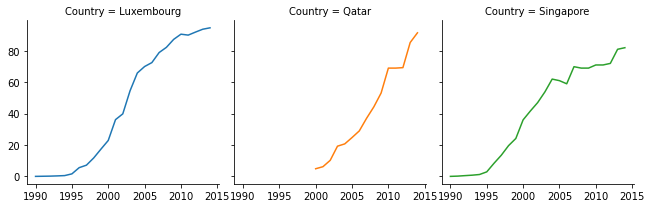

In [31]:
display(gdp_and_internet_use_2014.sort_values('GDP_Per_Capita', ascending = False).head(3))
grid = sns.FacetGrid(data = gdp_and_internet_use[gdp_and_internet_use['Country'].isin(['Luxembourg', 'Qatar', 'Singapore'])], col = 'Country', hue = 'Country')
grid.map_dataframe(sns.lineplot, x = 'Year', y = 'Internet_Users_Pct');

30. Create a scatter plot of Internet Use vs GDP per Capita for the year 2014. What do you notice?

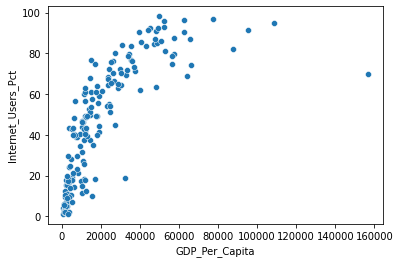

In [32]:
sns.scatterplot(data = gdp_and_internet_use_2014, x = 'GDP_Per_Capita', y = 'Internet_Users_Pct');

# The scatter plot shows a moderately strong positive correlation between GDP per capita and internet use.

31. Find the correlation between GDP per Capita and Internet Use for the year 2014. What is the meaning of this number?

In [33]:
display(np.corrcoef(gdp_and_internet_use_2014['GDP_Per_Capita'], gdp_and_internet_use_2014['Internet_Users_Pct']))

# The correlation coefficient between GDP per capita and internet is R = 0.825, meaning a significant and positive relationship exists between the two variables.

array([[1.       , 0.7604376],
       [0.7604376, 1.       ]])

32. Add a column to `gdp_and_internet_use_2014` and calculate the logarithm of GDP per capita. Find the correlation between the log of GDP per capita and internet users percentage. How does this compare to the calculation in the previous part?

In [34]:
gdp_and_internet_use_2014 = gdp_and_internet_use_2014.assign(Log_GDP_Per_Capita = lambda x: np.log(x['GDP_Per_Capita']))
display(np.corrcoef(gdp_and_internet_use_2014['Log_GDP_Per_Capita'], gdp_and_internet_use_2014['Internet_Users_Pct']))

# The correlation coefficient between the log of GDP per capita and internet use is R = 0.904, which is higher than before.

array([[1.       , 0.8983196],
       [0.8983196, 1.       ]])

33. Filter the original dataset down to just the United States for all available years. Calculate correlation between internet use and gdp per capita. Is this meaningful or useful?

In [35]:
united_states = gdp_and_internet_use[gdp_and_internet_use['Country'] == 'United States']
display(np.corrcoef(united_states['GDP_Per_Capita'], united_states['Internet_Users_Pct']))

# This correlation tells us the relationship between GDP per capita growth and internet use growth in the United States is linear over time.

array([[1.        , 0.99166007],
       [0.99166007, 1.        ]])

### Solo Exploration and Presentation:
1. Choose and download another data set from the UN data [http://data.un.org/Explorer.aspx](http://data.un.org/Explorer.aspx) to merge with your data and explore. Prepare a short (< 5 minute) presentation of your findings. Report any interesting correlations you find. Include visualizations and consider adding interactivity with `ipywidgets`. This presentation can be done either in a Jupyter Notebook or using another presentation software, such as PowerPoint. Check out [Jupyter Slides](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f) if you have time. This allows you to turn your jupyter notebook into a slideshow.
2.    If time allows, check out the plotly library to add additional interativity to your plots. [https://plotly.com/python/plotly-express/](https://plotly.com/python/plotly-express/).


In [36]:
tourism_df = pd.read_csv('../data/inbound_tourism.csv', na_values = '..')
tourism_df = tourism_df.melt(id_vars = ['Country'], var_name = 'Year', value_name = 'Total_Arrivals')
tourism_df['Country'] = tourism_df['Country'].str.title()
tourism_df['Total_Arrivals'] = pd.to_numeric(tourism_df['Total_Arrivals'].str.replace(',', ''))
tourism_df['Year'] = pd.to_numeric(tourism_df['Year'])

In [37]:
gdp_internet_tourism_matches = match_countries(gdp_and_internet_use, tourism_df)
display(gdp_internet_tourism_matches)

{'Slovakia': 'Slovak Republic',
 'Bahamas': 'The Bahamas',
 'Sao Tome And Principe': 'Sao Tome and Principe',
 'Russian Federation': 'Russia',
 'Viet Nam': 'Vietnam',
 'Moldova, Republic Of': 'Moldova',
 'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
 'Congo, Democratic Republic Of The': 'Dem. Rep. Congo',
 'Hong Kong, China': 'Hong Kong SAR, China',
 'Trinidad And Tobago': 'Trinidad and Tobago',
 'Kyrgyzstan': 'Kyrgyz Republic',
 'Saint Vincent And The Grenadines': 'St. Vincent and the Grenadines',
 'Brunei Darussalam': 'Brunei',
 'Iran, Islamic Republic Of': 'Iran',
 'Saint Kitts And Nevis': 'St. Kitts and Nevis',
 'Lao People�S Democratic Republic': 'Lao PDR',
 'Macao, China': 'Macao SAR, China',
 'Saint Lucia': 'St. Lucia',
 'Bolivia, Plurinational State Of': 'Bolivia',
 'Antigua And Barbuda': 'Antigua and Barbuda',
 'Gambia': 'The Gambia'}

In [38]:
tourism_df = tourism_df.assign(temp = list(map(gdp_internet_tourism_matches.get, tourism_df['Country'])))
tourism_df['Country'] = np.where(~tourism_df['temp'].isna(), tourism_df['temp'], tourism_df['Country'])
tourism_df = tourism_df.drop(columns = 'temp')
gdp_internet_tourism = gdp_and_internet_use.merge(tourism_df, on = ['Country', 'Year'])

In [88]:
gdp_internet_tourism_2014 = gdp_internet_tourism[gdp_internet_tourism['Year'] == 2014].dropna()
africa_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'Africa']
asia_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'Asia']
europe_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'Europe']
oceania_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'Oceania']
north_america_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'North America']
south_america_2014 = gdp_internet_tourism_2014[gdp_internet_tourism_2014['Continent'] == 'South America']

array([[1.        , 0.58257302],
       [0.58257302, 1.        ]])

array([[1.        , 0.18578767],
       [0.18578767, 1.        ]])

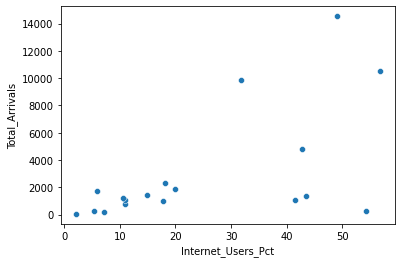

In [108]:
sns.scatterplot(data = africa_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(africa_2014['Internet_Users_Pct'], africa_2014['Total_Arrivals']))
display(np.corrcoef(africa_2014['GDP_Per_Capita'], africa_2014['Total_Arrivals']))

array([[1.        , 0.12800881],
       [0.12800881, 1.        ]])

array([[1.      , 0.099758],
       [0.099758, 1.      ]])

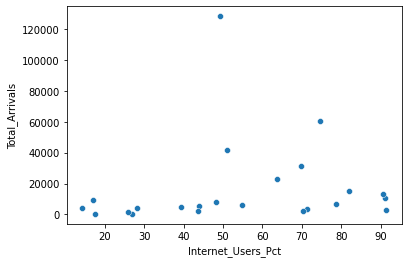

In [94]:
sns.scatterplot(data = asia_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(asia_2014['Internet_Users_Pct'], asia_2014['Total_Arrivals']))
display(np.corrcoef(asia_2014['GDP_Per_Capita'], asia_2014['Total_Arrivals']))

array([[1.        , 0.18856602],
       [0.18856602, 1.        ]])

array([[1.       , 0.3295825],
       [0.3295825, 1.       ]])

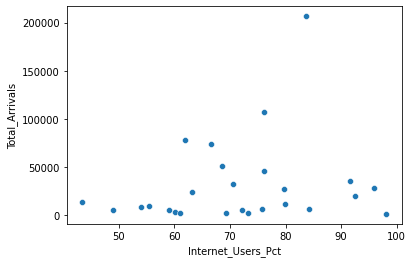

In [95]:
sns.scatterplot(data = europe_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(europe_2014['Internet_Users_Pct'], europe_2014['Total_Arrivals']))
display(np.corrcoef(europe_2014['GDP_Per_Capita'], europe_2014['Total_Arrivals']))

array([[1.        , 0.83612351],
       [0.83612351, 1.        ]])

array([[1.        , 0.93010371],
       [0.93010371, 1.        ]])

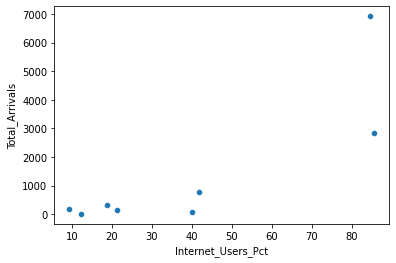

In [97]:
sns.scatterplot(data = oceania_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(oceania_2014['Internet_Users_Pct'], oceania_2014['Total_Arrivals']))
display(np.corrcoef(oceania_2014['GDP_Per_Capita'], oceania_2014['Total_Arrivals']))

array([[1.        , 0.01244693],
       [0.01244693, 1.        ]])

array([[1.        , 0.04986571],
       [0.04986571, 1.        ]])

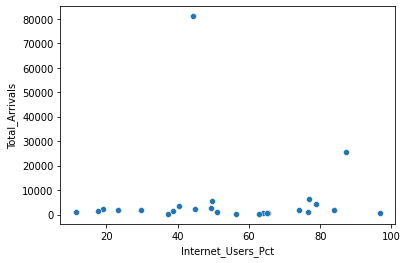

In [98]:
sns.scatterplot(data = north_america_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(north_america_2014['Internet_Users_Pct'], north_america_2014['Total_Arrivals']))
display(np.corrcoef(north_america_2014['GDP_Per_Capita'], north_america_2014['Total_Arrivals']))

array([[1.        , 0.55126402],
       [0.55126402, 1.        ]])

array([[1.        , 0.16201522],
       [0.16201522, 1.        ]])

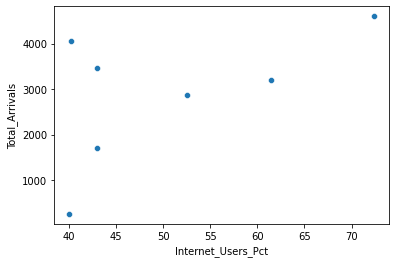

In [99]:
sns.scatterplot(data = south_america_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(south_america_2014['Internet_Users_Pct'], south_america_2014['Total_Arrivals']))
display(np.corrcoef(south_america_2014['GDP_Per_Capita'], south_america_2014['Total_Arrivals']))

array([[1.        , 0.27554311],
       [0.27554311, 1.        ]])

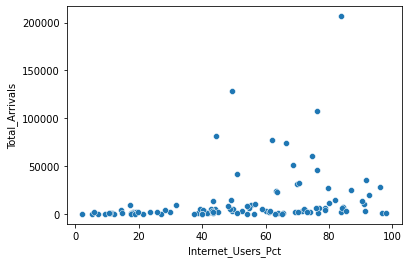

In [106]:
sns.scatterplot(data = gdp_internet_tourism_2014, x = 'Internet_Users_Pct', y = 'Total_Arrivals');
display(np.corrcoef(gdp_internet_tourism_2014['Internet_Users_Pct'], gdp_internet_tourism_2014['Total_Arrivals']))

array([[1.        , 0.22562748],
       [0.22562748, 1.        ]])

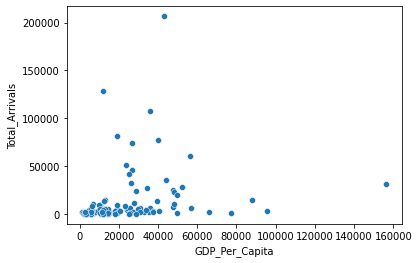

In [107]:
sns.scatterplot(data = gdp_internet_tourism_2014, x = 'GDP_Per_Capita', y = 'Total_Arrivals');
display(np.corrcoef(gdp_internet_tourism_2014['GDP_Per_Capita'], gdp_internet_tourism_2014['Total_Arrivals']))